In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\Sai charan\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
con1 = sqlite3.connect('final.sqlite')

# Eliminating neutral reviews i.e. those reviews with Score = 3
filtered_data = pd.read_sql_query(" SELECT * FROM Reviews  ", con1)

print(filtered_data.shape)
filtered_data.head()

(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final.shape)

#Checking to see how much % of data still remains
((final.shape[0]*1.0)/(filtered_data.shape[0]*1.0)*100)

(364171, 12)


100.0

In [4]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [5]:
final = final[final['ProductId'] != '2841233731']
final = final[final['ProductId'] != '0006641040']
final.shape

(364136, 12)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization

In [6]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
words_to_keep = set(('not'))
stop -= words_to_keep
#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')

 #function to clean the word of any html-tags
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [7]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    
    final_string.append(str1)
    i+=1

In [8]:
final['CleanedText']=final_string  
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (364136, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
34,476617,515426,141278509X,AB1A5EGHHVA9M,CHelmic,1,1,positive,1332547200,The best drink mix,This product by Archer Farms is the best drink...,product archer farm best drink mix ever mix fl...
36,22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,dog love chicken product china wont buy anymor...
35,22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,positive,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dog love saw pet store tag attach regard made ...
142,157910,171225,7310172001,A314APAWYQFKBJ,"Diana Hersholt ""dog lover""",1,1,positive,1104796800,My dog loves these!,My dog is a very picky eater. She has a very ...,dog picki eater sensit stomach special food tr...
143,157909,171224,7310172001,AK0CENM3LUM28,Ana Mardoll,1,1,positive,1222732800,Pure Puppy Addiction,Pro-Treat Freeze Dried Liver Dog Treats / B000...,freez dri liver dog treat sort product make wi...


In [9]:


# We will collect different 30K rows without repetition from time_sorted_data dataframe
my_final = final[:30000]
my_final.sort_values('Time',inplace=True) 
sample = my_final['CleanedText'].values

# Defining 'WordVector' Class to compute word vectors using TruncatedSVD

In [10]:
class WordVector:
    
    
    # Initialising the max_features and sample_data to pass in TFIDF vectorizer
    def __init__(self, max_feat , sample_data):
        self.max_feat = max_feat # No.of top words
        self.sample_data = sample_data # document to vectorize
        # List of all top max_feat words
        self.top_words = []
        self.freq = []
    
    # Picking top max_feat words by using TFIDF vextorizer 
    def topWords(self):
        tf_idf_vect = TfidfVectorizer(max_features=self.max_feat)
        tfidf_vec = tf_idf_vect.fit_transform(self.sample_data)
        print("the type of count vectorizer :",type(tfidf_vec))
        print("the shape of out text TFIDF vectorizer : ",tfidf_vec.get_shape())
        print("the number of unique words :", tfidf_vec.get_shape()[1])
        
        # Top 'n' words
        self.top_words = tf_idf_vect.get_feature_names()
        # tfidf frequencies of top 'n' words
        self.freq = tf_idf_vect.idf_
        
        return tf_idf_vect.get_feature_names()
    
    # Computing the co-occurrence matrix with value of neighbourhood as neighbour_num
    def cooccurrenceMatrix(self, neighbour_num , list_words):
        
        # Storing all words with their indices in the dictionary
        corpus = dict()
        # List of all words in the corpus
        doc = []
        index = 0
        for sent in self.sample_data:
            for word in sent.split():
                doc.append(word)
                corpus.setdefault(word,[])
                corpus[word].append(index)
                index += 1
        
        # Co-occurrence matrix
        matrix = []
        # rows in co-occurrence matrix
        for row in list_words:
            # row in co-occurrence matrix
            temp = []
            # column in co-occurrence matrix 
            for col in list_words :
                if( col != row):
                    # No. of times col word is in neighbourhood of row word
                    count = 0
                    # Value of neighbourhood
                    num = neighbour_num
                    # Indices of row word in the corpus
                    positions = corpus[row]
                    for i in positions:
                        if i<(num-1):
                            # Checking for col word in neighbourhood of row
                            if col in doc[i:i+num]:
                                count +=1
                        elif (i>=(num-1)) and (i<=(len(doc)-num)):
                            # Check col word in neighbour of row
                            if (col in doc[i-(num-1):i+1]) and (col in doc[i:i+num]):
                                count +=2
                            # Check col word in neighbour of row
                            elif (col in doc[i-(num-1):i+1]) or (col in doc[i:i+num]):
                                count +=1
                        else :
                            if (col in doc[i-(num-1):i+1]):
                                count +=1
                            
                                
                    # appending the col count to row of co-occurrence matrix
                    temp.append(count)
                else:
                    # Append 0 in the column if row and col words are equal
                    temp.append(0)
            # appending the row in co-occurrence matrix        
            matrix.append(temp)
        # Return co-occurrence matrix
        return np.array(matrix) 
    
    
    # Function to draw Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence
    def plotCumulativeVariance(self, co_occurrence_matrix):
        #Applying TruncatedSVD
        from sklearn.decomposition import TruncatedSVD
        max_features = co_occurrence_matrix.shape[1]-1
        svd = TruncatedSVD(n_components=max_features)
        svd_data = svd.fit_transform(co_occurrence_matrix)
        percentage_var_explained = svd.explained_variance_ / np.sum(svd.explained_variance_)
        cum_var_explained = np.cumsum(percentage_var_explained)
        # Plot the TrunvatedSVD spectrum
        plt.figure(1, figsize=(6, 4))
        plt.clf()
        plt.plot(cum_var_explained, linewidth=2)
        plt.axis('tight')
        plt.grid()
        plt.xlabel('n_components')
        plt.ylabel('Cumulative_explained_variance')
        plt.title("Cumulative_explained_variance VS n_components")
        plt.show()
        
    # Function to get matrix of word_vectors U'(n*k matrix) using TruncatedSVD . Here 'k' is the optimal number of features
    # Here pass co-occurrence matrix  and optimal no. of components
    def computeVectors(self, co_occurrence_matrix, num_components):
        from sklearn.decomposition import TruncatedSVD
        svd_trunc = TruncatedSVD(n_components=num_components)
        svd_transform = svd_trunc.fit_transform(co_occurrence_matrix)
        # Returns Transformed matrix of Word-Vectors
        return svd_transform
    
    # Applying k-means clustering and obtaining all the clusters
    def getClusters(self, num_clusters, matrix_word_vec):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=num_clusters, n_jobs=-1).fit(matrix_word_vec)
        index = [i for i in range(len(self.top_words))]
        d = dict()
        for (key, value) in zip(kmeans.labels_, index):
            d.setdefault(key,[])
            d[key].append(value)
        # List of all clusters
        clusters = []
        labels = sorted(list(set(kmeans.labels_)))
        for i in labels:
            temp = []
            for idx in sorted(d[i]):
                temp.append(self.top_words[idx])
            clusters.append(temp)
            
        # Return the list of clusters
        return clusters
    
    # Function to generate word cloud
    def generateWordCloud(self, list_of_words):
        from wordcloud import WordCloud, STOPWORDS
        stopwords = set(STOPWORDS)
        
        # Dictionary consisting of words as keys and their frequencies as values
        word_dict = {word : self.freq[self.top_words.index(word)] for word in list_of_words}
        
        # Initialising and generating wordcloud
        wc = WordCloud(background_color='white', stopwords=stopwords, max_words=100, max_font_size=40, random_state=42)
        wc.generate_from_frequencies(word_dict)
        
        # Show wordcloud
        plt.figure(figsize = (12, 8), facecolor = None)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()

# Using WordVector class for computing Word Vectors for top 2K words

In [11]:
wv = WordVector(2000,sample)

# Picking top 2K words
words_top = wv.topWords()

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (30000, 2000)
the number of unique words : 2000


Shape of co-occurrence matrix :  (2000, 2000)




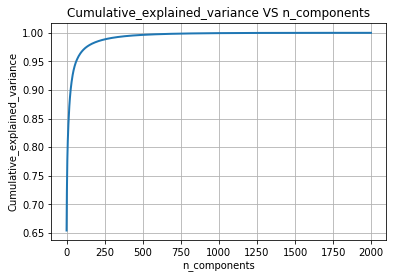

In [12]:
# Computing the co-occurrence matrix for 'words_top' with value of neighbourhood = 5
co_occ_matrix = wv.cooccurrenceMatrix(5, words_top)
print("Shape of co-occurrence matrix : ",co_occ_matrix.shape )
print('\n')

# drawing Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence matrix
wv.plotCumulativeVariance(co_occ_matrix)

In [13]:
# Computing word vectors with 250 components
word_vec_matrix = wv.computeVectors(co_occ_matrix, 250)
print("Shape of word-vector : ",word_vec_matrix.shape)

# Applying k-means with no_of_clusters = 50 on 'word_vec_matrix' and get all clusters
#word_cluster = wv.getClusters(50, word_vec_matrix)

Shape of word-vector :  (2000, 250)


In [14]:
from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(word_vec_matrix)
    loss.append(kmeans.inertia_)

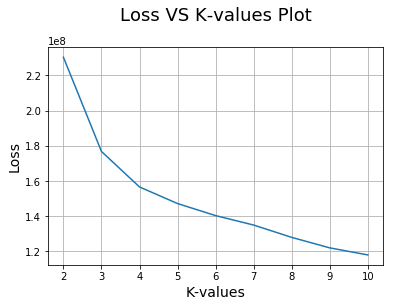

In [15]:
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [34]:
word_cluster = wv.getClusters(4, word_vec_matrix)

# Seeing Words In The Clusters

In [40]:
print("Words in Cluster- 1 :\n",word_cluster[0][12:86])

Words in Cluster- 1 :
 ['address', 'adjust', 'admit', 'adopt', 'ador', 'adult', 'advertis', 'advic', 'advis', 'affect', 'afford', 'afraid', 'afternoon', 'aftertast', 'afterward', 'age', 'agre', 'ahead', 'aid', 'air', 'alcohol', 'aliv', 'allerg', 'allergi', 'allow', 'almond', 'alon', 'along', 'alot', 'alreadi', 'altern', 'although', 'america', 'american', 'among', 'anim', 'answer', 'antioxid', 'anymor', 'anytim', 'anyway', 'anywher', 'apart', 'appar', 'appeal', 'appear', 'appetit', 'appl', 'appli', 'appreci', 'appropri', 'approxim', 'area', 'arent', 'aroma', 'aromat', 'artifici', 'asian', 'asid', 'ask', 'associ', 'assort', 'assum', 'ate', 'attach', 'attempt', 'attent', 'attract', 'authent', 'averag', 'avoid', 'aw', 'awar', 'awesom']


In [42]:
print("Words in Cluster- 2 :\n",word_cluster[2])

Words in Cluster- 49 :
 ['dog', 'flavor', 'food', 'get', 'good', 'great', 'like', 'love', 'one', 'product', 'tast', 'tea', 'tri', 'use']


In [36]:
print("Words in Cluster- 3 :\n",word_cluster[3][27:37])

Words in Cluster- 49 :
 ['butter', 'came', 'can', 'candi', 'cant', 'care', 'chees', 'chew', 'chicken', 'chocol']


SUMMARY :- By observing above cluster we can conclude that words in cluster are related to eatables

# Word Clouds

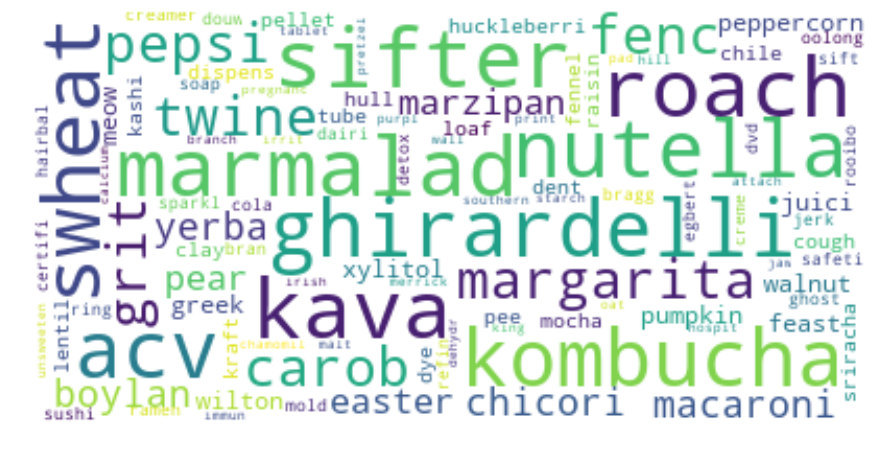

In [38]:
wv.generateWordCloud(word_cluster[0])

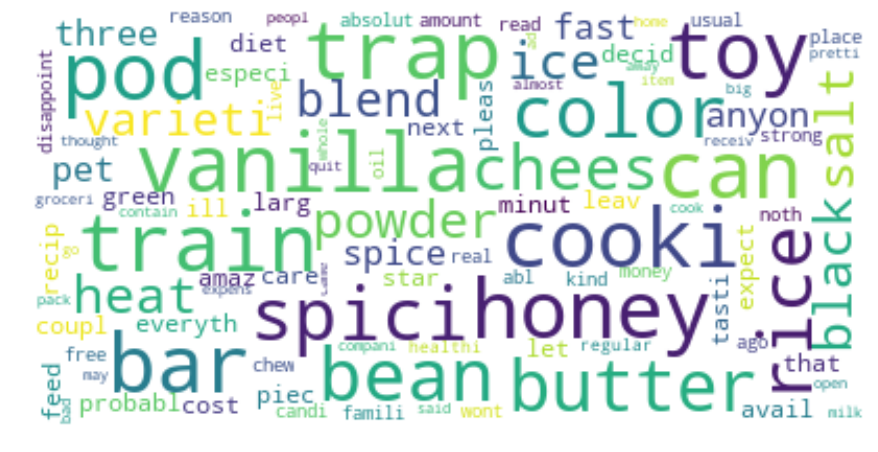

In [39]:
wv.generateWordCloud(word_cluster[3])

# Using WordVector class for computing Word Vectors of top 5K words

In [15]:
wv1 = WordVector(5000,sample)

# Picking top 5000 words
words_top_5000 = wv1.topWords()

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (30000, 5000)
the number of unique words : 5000


Shape of co-occurrence matrix :  (5000, 5000)




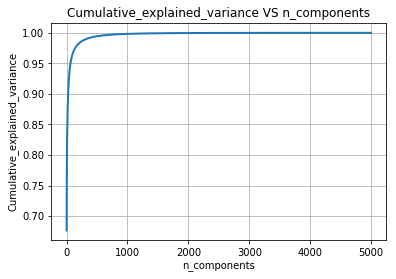

In [16]:
co_occ_matrix = wv1.cooccurrenceMatrix(5, words_top_5000)
print("Shape of co-occurrence matrix : ",co_occ_matrix.shape )
print('\n')

# drawing Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence matrix
wv1.plotCumulativeVariance(co_occ_matrix)

In [17]:
# Computing word vectors with 500 components
word_vec_matrix = wv1.computeVectors(co_occ_matrix, 500)
print("Shape of word-vector : ",word_vec_matrix.shape)

# Applying k-means with no_of_clusters = 50 on 'word_vec_matrix' and get all clusters
#word_cluster = wv1.getClusters(50, word_vec_matrix)

Shape of word-vector :  (5000, 500)


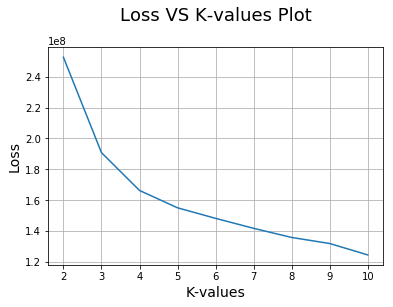

In [18]:
from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(word_vec_matrix)
    loss.append(kmeans.inertia_)
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [20]:
word_cluster = wv1.getClusters(4, word_vec_matrix)

# Seeing Words In The Clusters

In [29]:
print("Words in Cluster- 2 :\n",word_cluster[2])

Words in Cluster- 2 :
 ['dog', 'flavor', 'food', 'get', 'good', 'great', 'like', 'love', 'make', 'one', 'product', 'tast', 'tea', 'tri', 'use']


In [26]:
print("Words in Cluster- 1 :\n",word_cluster[0])

Words in Cluster- 1 :
 ['abil', 'absorb', 'abund', 'abus', 'accent', 'accept', 'access', 'accid', 'accident', 'accompani', 'accomplish', 'accord', 'account', 'accur', 'accustom', 'ach', 'achiev', 'acid', 'acknowledg', 'acn', 'acquir', 'acr', 'across', 'act', 'action', 'activ', 'actor', 'acv', 'adagio', 'adam', 'adapt', 'addict', 'addit', 'address', 'adequ', 'adher', 'adjust', 'admir', 'admit', 'adopt', 'ador', 'adult', 'advanc', 'advantag', 'adventur', 'advers', 'advertis', 'advic', 'advil', 'advis', 'affair', 'affect', 'affili', 'afford', 'afghanistan', 'aficionado', 'afraid', 'africa', 'african', 'afterlif', 'afternoon', 'aftertast', 'afterward', 'agav', 'age', 'agent', 'aggress', 'agre', 'ahead', 'ahi', 'aid', 'aidel', 'ailment', 'aim', 'aint', 'air', 'airlin', 'airport', 'airtight', 'aisl', 'aka', 'akita', 'al', 'ala', 'alarm', 'alaska', 'albeit', 'albertson', 'album', 'alcohol', 'ale', 'alec', 'alert', 'alex', 'alfalfa', 'alfredo', 'alik', 'alittl', 'aliv', 'allerg', 'allergen', '

In [27]:
print("Words in Cluster- 2 :\n",word_cluster[1])

Words in Cluster- 2 :
 ['also', 'amazon', 'bag', 'best', 'better', 'bought', 'box', 'brand', 'buy', 'cat', 'chocol', 'coffe', 'day', 'differ', 'dont', 'drink', 'eat', 'enjoy', 'even', 'ever', 'find', 'first', 'found', 'give', 'high', 'hot', 'ive', 'know', 'littl', 'look', 'mani', 'mix', 'much', 'need', 'never', 'order', 'price', 'purchas', 'realli', 'recommend', 'review', 'sauc', 'say', 'ship', 'sinc', 'store', 'stuff', 'thing', 'think', 'time', 'treat', 'two', 'want', 'way', 'well', 'work', 'would', 'year']


In [28]:
print("Words in Cluster- 4:\n",word_cluster[3])

Words in Cluster- 4:
 ['abl', 'absolut', 'actual', 'ad', 'add', 'ago', 'almost', 'although', 'alway', 'amaz', 'amount', 'anoth', 'anyon', 'anyth', 'around', 'arriv', 'avail', 'away', 'back', 'bad', 'bake', 'bar', 'base', 'bean', 'believ', 'big', 'bit', 'bitter', 'black', 'blend', 'bone', 'bottl', 'bread', 'brew', 'butter', 'cake', 'call', 'calori', 'came', 'can', 'candi', 'cant', 'care', 'carri', 'case', 'chang', 'cheaper', 'chees', 'chew', 'chicken', 'clean', 'cold', 'color', 'come', 'compani', 'compar', 'contain', 'cook', 'cooki', 'corn', 'cost', 'could', 'couldnt', 'coupl', 'cream', 'cup', 'dark', 'deal', 'decid', 'definit', 'delici', 'didnt', 'diet', 'disappoint', 'dish', 'doesnt', 'dri', 'easi', 'effect', 'egg', 'either', 'els', 'end', 'enough', 'especi', 'everi', 'everyon', 'everyth', 'exact', 'excel', 'expect', 'expens', 'experi', 'extra', 'fact', 'famili', 'far', 'fast', 'favorit', 'feed', 'feel', 'fill', 'fine', 'free', 'fresh', 'friend', 'full', 'gave', 'gift', 'glad', 'go', 

# Word Clouds

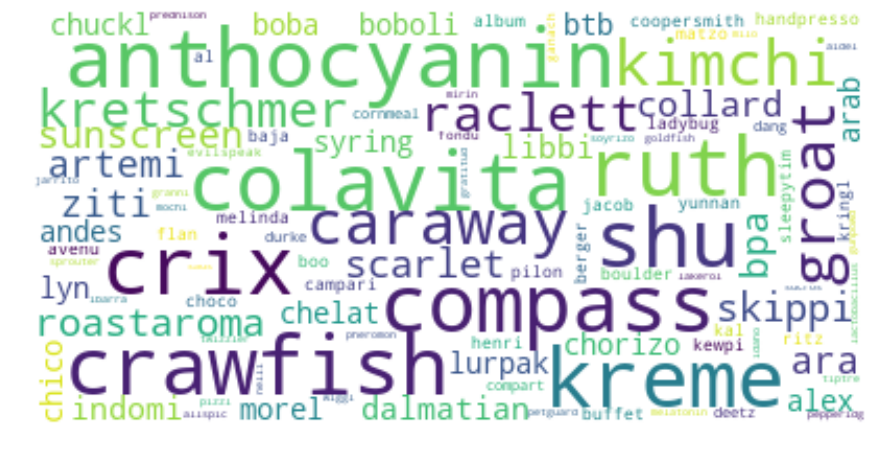

In [25]:
wv1.generateWordCloud(word_cluster[0])

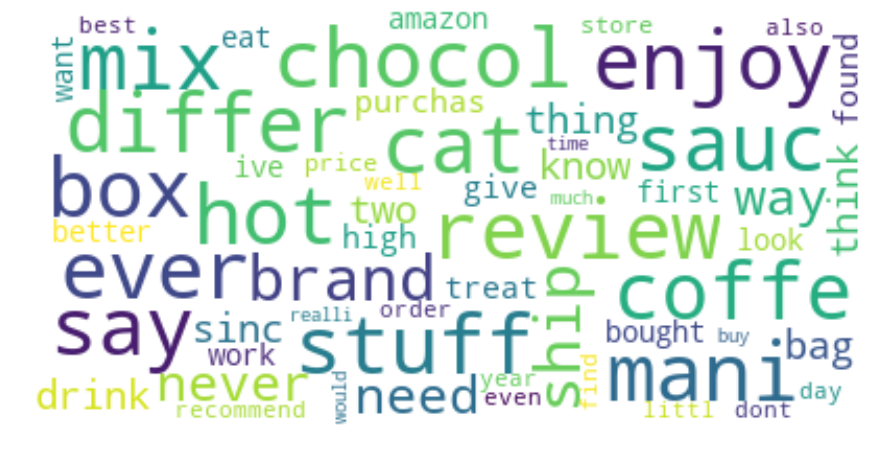

In [30]:
wv1.generateWordCloud(word_cluster[1])

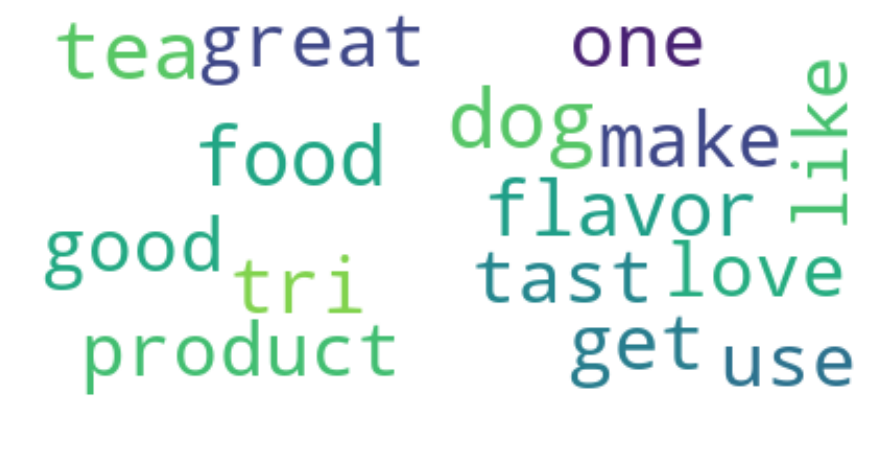

In [24]:
wv1.generateWordCloud(word_cluster[2])

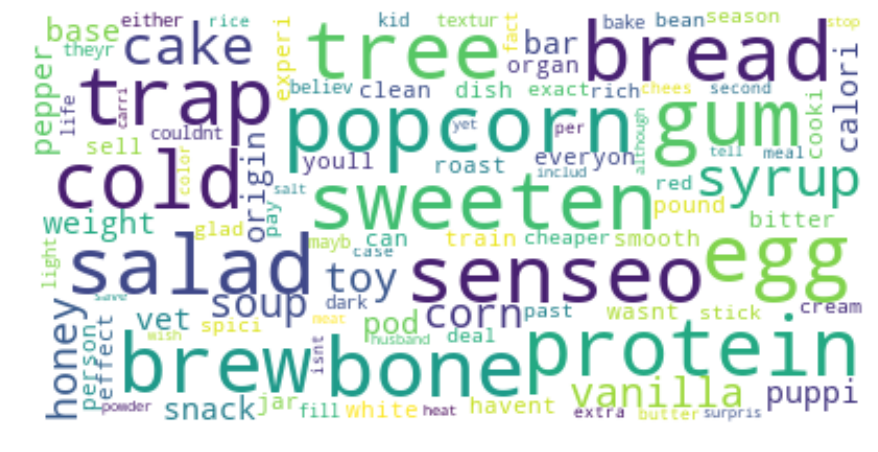

In [31]:
wv1.generateWordCloud(word_cluster[3])

# Using WordVector class for computing Word Vectors of top 10K words

In [11]:
wv2 = WordVector(10000,sample)

# Picking top 10K words
words_top_10k = wv2.topWords()

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (30000, 10000)
the number of unique words : 10000


Shape of co-occurrence matrix :  (10000, 10000)




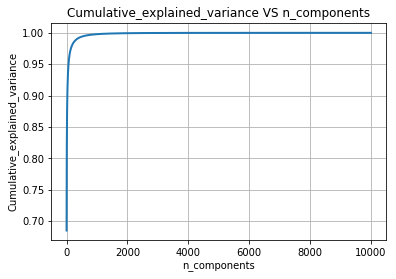

In [12]:
co_occ_matrix = wv2.cooccurrenceMatrix(5, words_top_10k)
print("Shape of co-occurrence matrix : ",co_occ_matrix.shape )
print('\n')

# drawing Cumulative_explained_variance VS n_components plot to find optimal number of components for co-occurrence matrix
wv2.plotCumulativeVariance(co_occ_matrix)

In [13]:
word_vec_matrix = wv2.computeVectors(co_occ_matrix, 1000)
print("Shape of word-vector : ",word_vec_matrix.shape)

# Applying k-means with no_of_clusters = 50 on 'word_vec_matrix' and get all clusters
#word_cluster = wv2.getClusters(50, word_vec_matrix)

Shape of word-vector :  (10000, 1000)


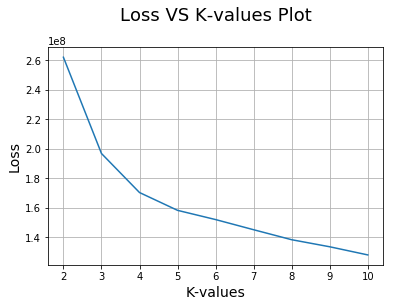

In [14]:
from sklearn.cluster import KMeans

k_values = [2,3,4,5,6,7,8,9,10]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(word_vec_matrix)
    loss.append(kmeans.inertia_)
plt.plot(k_values, loss)
plt.xlabel('K-values',size=14)
plt.ylabel('Loss',size=14)
plt.title('Loss VS K-values Plot\n',size=18)
plt.grid()
plt.show()

In [15]:
# Applying k-means with no_of_clusters = 50 on 'word_vec_matrix' and get all clusters
word_cluster = wv2.getClusters(4, word_vec_matrix)

# Seeing Words In The Clusters

In [18]:
print("Words in Cluster- 1 :\n",word_cluster[0])

Words in Cluster- 1 :
 ['aafco', 'aback', 'abandon', 'abbey', 'abbi', 'abc', 'abdomen', 'abdomin', 'abil', 'abnorm', 'abomin', 'abound', 'abras', 'abroad', 'abrupt', 'absenc', 'absent', 'absolutley', 'absorb', 'absorpt', 'absurd', 'abuelita', 'abund', 'abus', 'abut', 'acacia', 'academi', 'acai', 'acceler', 'accent', 'accept', 'access', 'accessori', 'accid', 'accident', 'acclim', 'accommod', 'accomod', 'accompani', 'accomplish', 'accord', 'account', 'accross', 'accumul', 'accur', 'accuraci', 'accus', 'accustom', 'ace', 'acet', 'aceto', 'ach', 'achey', 'achi', 'achiev', 'achiot', 'acid', 'acidi', 'acidophilus', 'acknowledg', 'acl', 'acn', 'acquaint', 'acquir', 'acr', 'acrid', 'across', 'act', 'action', 'activ', 'actor', 'acut', 'acv', 'adagio', 'adam', 'adapt', 'addict', 'address', 'adequ', 'adhd', 'adher', 'adhes', 'adjac', 'adject', 'adjust', 'administ', 'administr', 'admir', 'admit', 'adobo', 'adolesc', 'adopt', 'ador', 'adorn', 'adren', 'adult', 'adulter', 'adulthood', 'advanc', 'adv

In [19]:
print("Words in Cluster- 2 :\n",word_cluster[1])

Words in Cluster- 2 :
 ['also', 'amazon', 'bag', 'best', 'better', 'bought', 'box', 'brand', 'buy', 'cat', 'chocol', 'coffe', 'cup', 'day', 'differ', 'dont', 'drink', 'eat', 'enjoy', 'even', 'ever', 'find', 'first', 'found', 'give', 'high', 'hot', 'ive', 'know', 'littl', 'look', 'lot', 'mani', 'mix', 'much', 'need', 'never', 'order', 'price', 'purchas', 'qualiti', 'realli', 'recommend', 'review', 'sauc', 'say', 'ship', 'sinc', 'store', 'stuff', 'thing', 'think', 'time', 'treat', 'two', 'want', 'way', 'well', 'work', 'would', 'year']


In [20]:
print("Words in Cluster- 3 :\n",word_cluster[2])

Words in Cluster- 3 :
 ['dog', 'flavor', 'food', 'get', 'good', 'great', 'like', 'love', 'make', 'one', 'product', 'tast', 'tea', 'tri', 'use']


In [21]:
print("Words in Cluster- 4 :\n",word_cluster[3])

Words in Cluster- 4 :
 ['abl', 'absolut', 'actual', 'ad', 'add', 'addit', 'ago', 'almost', 'although', 'alway', 'amaz', 'amount', 'anoth', 'anyon', 'anyth', 'around', 'arriv', 'avail', 'away', 'back', 'bad', 'bake', 'bar', 'base', 'bean', 'believ', 'big', 'bit', 'bitter', 'black', 'blend', 'bone', 'bottl', 'bread', 'brew', 'butter', 'cake', 'call', 'calori', 'came', 'can', 'candi', 'cant', 'care', 'carri', 'case', 'chang', 'cheaper', 'chees', 'chew', 'chicken', 'christma', 'clean', 'coat', 'cocoa', 'cold', 'color', 'come', 'compani', 'compar', 'contain', 'continu', 'cook', 'cooki', 'corn', 'cost', 'could', 'couldnt', 'coupl', 'cream', 'cut', 'dark', 'deal', 'decid', 'definit', 'delici', 'didnt', 'diet', 'disappoint', 'dish', 'doesnt', 'dri', 'easi', 'effect', 'egg', 'either', 'els', 'end', 'enough', 'especi', 'espresso', 'everi', 'everyon', 'everyth', 'exact', 'excel', 'expect', 'expens', 'experi', 'extra', 'fact', 'famili', 'far', 'fast', 'favorit', 'feed', 'feel', 'fill', 'fine', 'fi

# Word Clouds

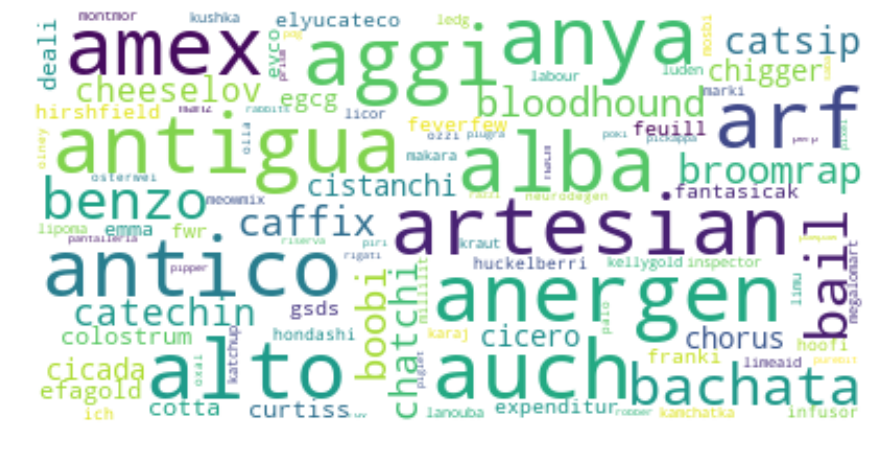

In [22]:
wv2.generateWordCloud(word_cluster[0])

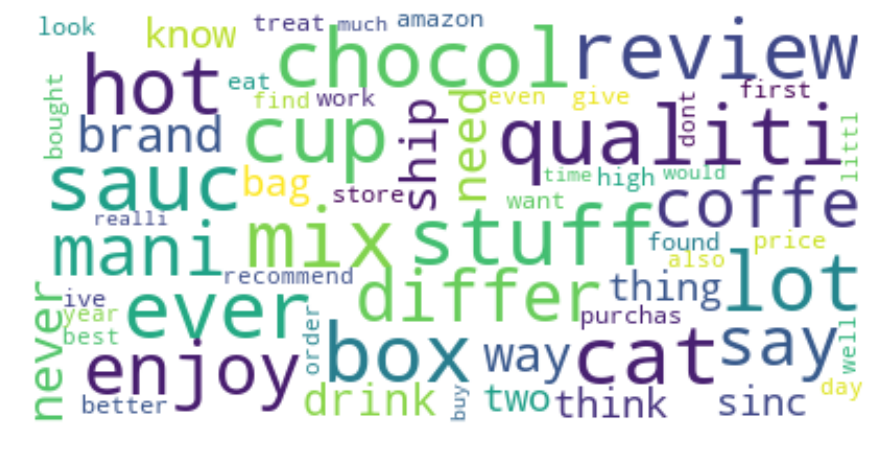

In [23]:
wv2.generateWordCloud(word_cluster[1])

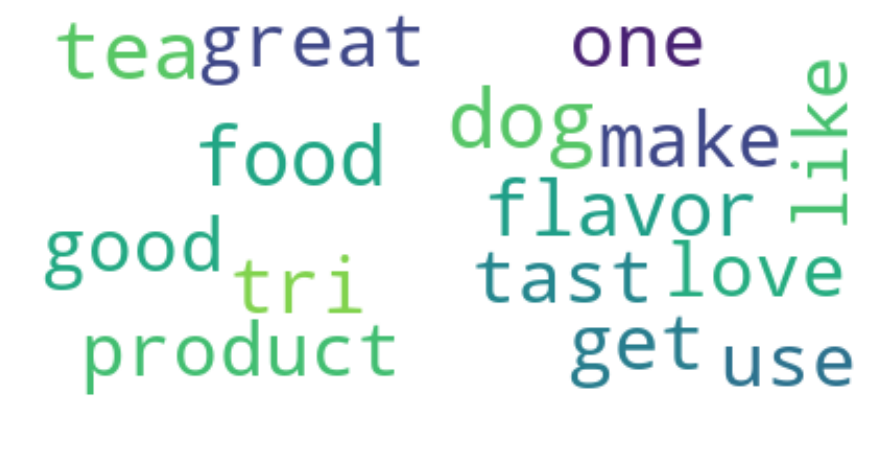

In [24]:
wv2.generateWordCloud(word_cluster[2])

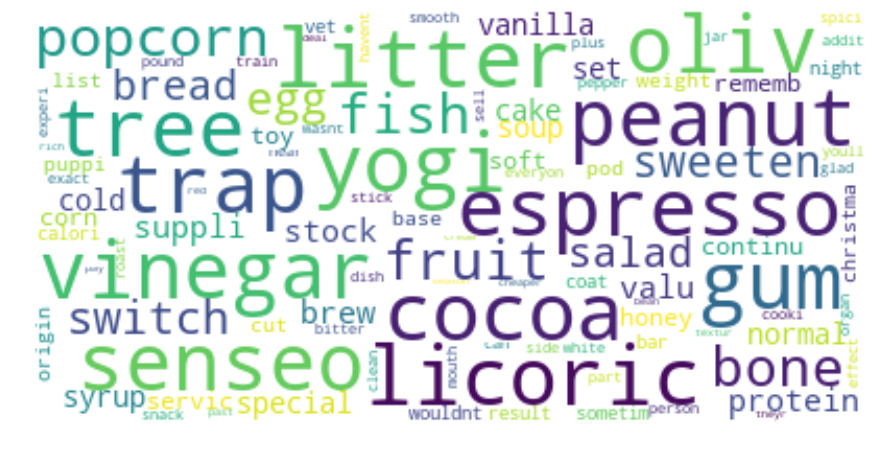

In [25]:
wv2.generateWordCloud(word_cluster[3])